In [45]:
import sqlite3
import json

con = sqlite3.connect("git.db")
cur = con.cursor()

In [44]:
## Run to delete .db file if 
## sqlite3 git.db ".read store.sql"
## does not work
con.close()

In [46]:
# specify the path to the JSON file
json_file_path = "events.json"

# open the file and load its contents into a Python object
# with open(json_file_path, "r") as f:
with open(json_file_path, encoding='utf-8') as f:
    json_data = json.load(f)
## Parsing
for entry in json_data:
    ##print(entry)
    ##General Information Insertion
    user_id = entry['actor']['id']
    repo_id = entry['repo']['id']
    event_id = entry['id']
    event_type = entry['type']
    cur.execute("INSERT OR IGNORE INTO Users VALUES (?, ?, ?, ?, ?, ?)", (user_id, entry['actor']['login'], entry['actor']['display_login'], entry['actor']['gravatar_id'], entry['actor']['url'], entry['actor']['avatar_url']))
    cur.execute("INSERT OR IGNORE INTO Repo VALUES (?, ?, ?)", (repo_id, entry['repo']['name'], entry['repo']['url']))     
    con.commit()
    ##Org Insertion if needed
    try:
        org = entry['org']
        cur.execute("INSERT OR IGNORE INTO Org VALUES (?, ?, ?, ?, ?)", (org['id'], org['login'], org['gravatar_id'], org['url'], org['avatar_url']))
        con.commit()
    except KeyError:
        ##So program continues to execute
        pass


    ## CreateEvent Parsing
    if event_type == "CreateEvent":
        ##Event Relation Insertion
        cur.execute("INSERT INTO EventRelation VALUES (?, ?, ?, ?, ?, ?, ?)", (user_id, repo_id, event_type, event_id, org['id'], entry['public'], entry['created_at']))
        con.commit()
        
        ##Event details
        payload = entry['payload']

        cur.execute("INSERT INTO CreateEvent VALUES (?, ?, ?, ?, ?, ?)", (event_id, payload['ref'], payload['ref_type'], payload['master_branch'], payload['description'], payload['pusher_type']))
        con.commit()        

    if event_type == "DeleteEvent":
        ##Event Relation Insertion
        cur.execute("INSERT INTO EventRelation VALUES (?, ?, ?, ?, ?, ?, ?)", (user_id, repo_id, event_type, event_id, org['id'], entry['public'], entry['created_at']))
        con.commit()
        
        ##Event details
        payload = entry['payload']
        
        cur.execute("INSERT INTO DeleteEvent VALUES (?, ?, ?, ?)", (event_id, payload['ref'], payload['ref_type'], payload['pusher_type']))
        con.commit()
        
    ## PushEvent Parsing
    if event_type == "PushEvent":        
        # ##Event Relation Insertion
        cur.execute("INSERT INTO EventRelation VALUES (?, ?, ?, ?, ?, ?, ?)", (user_id, repo_id, event_type, event_id, org['id'], entry['public'], entry['created_at']))
        con.commit()

        payload = entry['payload']

        cur.execute("INSERT INTO PushEvent VALUES (?, ?, ?, ?, ?, ?, ?)", (event_id, payload['push_id'], payload['size'], payload['distinct_size'], payload['ref'], payload['head'], payload['before']))
        con.commit()
        

        commits = payload['commits']
        for i in commits:
            cur.execute("INSERT INTO PushCommit VALUES (?, ?, ?, ?, ?, ?, ?)", (i['sha'], i['author']['email'], i['author']['name'], i['message'], i['distinct'], i['url'], event_id))
            con.commit()
        
    ## IssueCommentEvent Parsing
    if event_type == "IssueCommentEvent":
        ##Event Relation Insertion
        cur.execute("INSERT INTO EventRelation VALUES (?, ?, ?, ?, ?, ?, ?)", (user_id, repo_id, event_type, event_id, org['id'], entry['public'], entry['created_at']))
        con.commit()

        ##Event Details
        payload = entry['payload']
        
        ##Start with IssueCommentEventTable
        cur.execute("INSERT INTO IssueCommentEvent VALUES (?, ?)", (event_id, payload['issue']['id']))
        con.commit()

        ##Next the Issue table
        issue = payload['issue']

        ##Edge cases and finer tuned parsing
        assignees = ""
        if len(payload_pull['assignees']) == 0:
            assignees = None
        else:
            for i in payload_pull['assignees']:
                assignees = assignees + str(i['id']) + ","
            ##take off last comma
            assignees.pop()

             
        cur.execute("INSERT INTO Issue VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", (issue['id'], issue['url'], \
                                            issue['repository_url'], issue['labels_url'], issue['comments_url'], issue['events_url'], issue['html_url'], issue['node_id'], \
                                            issue['number'], issue['title'], str(issue['labels']), issue['state'], issue['locked'], issue['assignee'], assignees))

        con.commit()

        ##Finally the comment itself
        comment = payload['comment']
        cur.execute("INSERT INTO IssueComment VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", (comment['url'], comment['html_url'], comment['issue_url'], comment['id'], issue['id'], comment['node_id'], comment['created_at'], \
                        comment['updated_at'], comment['author_association'], comment['body'], comment['user']['id']))
        con.commit()

    ## PullRequestingEvent
    if event_type == "PullRequestEvent":
        cur.execute("INSERT INTO EventRelation VALUES (?, ?, ?, ?, ?, ?, ?)", (user_id, repo_id, event_type, event_id, org['id'], entry['public'], entry['created_at']))
        con.commit()

        payload = entry['payload']
        payload_pull = payload['pull_request']

        ##Edge cases and finer tuned parsing
        author_assoc = payload_pull.get('author_association')
        if author_assoc == "NONE":
            author_assoc = None


        cur.execute("INSERT INTO PullRequestEvent VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", \
            (event_id, payload['number'], payload['pull_request']['id'], author_assoc, payload_pull.get('auto_merge'), \
                payload_pull.get('active_lock_reason'), payload_pull.get('merged'), payload_pull.get('mergeable'), payload_pull.get('rebaseable'), payload_pull.get('mergeable_state'), \
                    payload_pull.get('merged_by'), payload_pull['comments'], payload_pull['review_comments'], payload_pull['maintainer_can_modify'], payload_pull['commits'], payload_pull['additions'], \
                        payload_pull['deletions'], payload_pull['changed_files']))

        con.commit()
        
        ##Edge cases and finer tuned parsing
        assignees = ""
        if len(payload_pull['assignees']) == 0:
            assignees = None
        else:
            for i in payload_pull['assignees']:
                assignees = assignees + str(i['id']) + ","
            ##Remove last comma
            assignees.pop()
        
        requested_requested_reviewers = ""
        if len(payload_pull['requested_reviewers']) == 0:
            requested_reviewers = None
        else:
            for i in payload_pull['requested_reviewers']:
                requested_reviewers = requested_reviewers + str(i['id']) + ","
        
        requested_teams = ""
        if len(payload_pull['requested_teams']) == 0:
            requested_teams = None
        else:
            for i in payload_pull['requested_teams']:
                requested_teams = requested_teams + str(i['id']) + ","
        
        labels = ""
        if len(payload_pull['labels']) == 0:
            labels = None
        else:
            for i in payload_pull['labels']:
                labels = labels + str(i['id']) + ","


        cur.execute("INSERT INTO PullRequest VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", \
            (payload_pull['id'], payload_pull['url'], payload_pull['node_id'], payload_pull['html_url'], payload_pull['diff_url'], payload_pull['patch_url'], payload_pull['issue_url'], payload_pull['state'], payload_pull['locked'], payload_pull['title'], \
                payload_pull['body'], payload_pull['created_at'], payload_pull['updated_at'], payload_pull['closed_at'], payload_pull['merged_at'], payload_pull['assignee'], assignees, \
                    requested_reviewers, requested_teams, labels, payload_pull['commits_url'], payload_pull['review_comments_url'], payload_pull['review_comment_url'], payload_pull['comments_url'], payload_pull['statuses_url'], payload_pull['head']['sha'], payload_pull['base']['sha']))
        con.commit()
        

In [47]:
## Testing that all tables were properly populated
cur.execute("SELECT * FROM EventRelation")
print(cur.fetchall())

cur.execute("SELECT * FROM Org")
print(cur.fetchall())

cur.execute("SELECT COUNT(*) FROM EventRelation")
print(cur.fetchone())

cur.execute("SELECT * FROM PullRequestEvent")
print(cur.fetchone())

cur.execute("SELECT COUNT(*) FROM PullRequestEvent")
print(cur.fetchone())

cur.execute("SELECT * FROM IssueCommentEvent")
print(cur.fetchone())

cur.execute("SELECT * FROM Issue")
print(cur.fetchone())

cur.execute("SELECT * FROM IssueComment")
print(cur.fetchone())

cur.execute("SELECT * FROM PushEvent")
print(cur.fetchall())

cur.execute("SELECT * FROM PushCommit")
print(cur.fetchall())


[('29139614', '430598005', 'PullRequestEvent', '28179866050', '66235900', 1, '2023-04-04T00:59:23Z'), ('89292480', '619975637', 'PushEvent', '28179866036', '66235900', 1, '2023-04-04T00:59:23Z'), ('29139614', '450562930', 'DeleteEvent', '28179866067', '66235900', 1, '2023-04-04T00:59:23Z'), ('29139614', '331408599', 'PullRequestEvent', '28179866065', '66235900', 1, '2023-04-04T00:59:23Z'), ('57534678', '616150980', 'PushEvent', '28179866034', '66235900', 1, '2023-04-04T00:59:23Z'), ('41898282', '504079766', 'PushEvent', '28179866017', '66235900', 1, '2023-04-04T00:59:23Z'), ('107497590', '596781849', 'PushEvent', '28179865965', '66235900', 1, '2023-04-04T00:59:23Z'), ('129756781', '623228637', 'PushEvent', '28179866040', '66235900', 1, '2023-04-04T00:59:23Z'), ('29139614', '426979819', 'PullRequestEvent', '28179866008', '66235900', 1, '2023-04-04T00:59:23Z'), ('29139614', '137569154', 'DeleteEvent', '28179866014', '66235900', 1, '2023-04-04T00:59:23Z'), ('49699333', '484395347', 'Creat

In [ ]:
##For convenience
con.close()

1. Number of Events generated by user_id 29139614:  [(8,)]
2. Number of PullRequest Events by user_id 29139614 [(5,)]
3. Event Type and Count:  [('CreateEvent', 1), ('DeleteEvent', 4), ('IssueCommentEvent', 1), ('PullRequestEvent', 5), ('PushEvent', 15)]


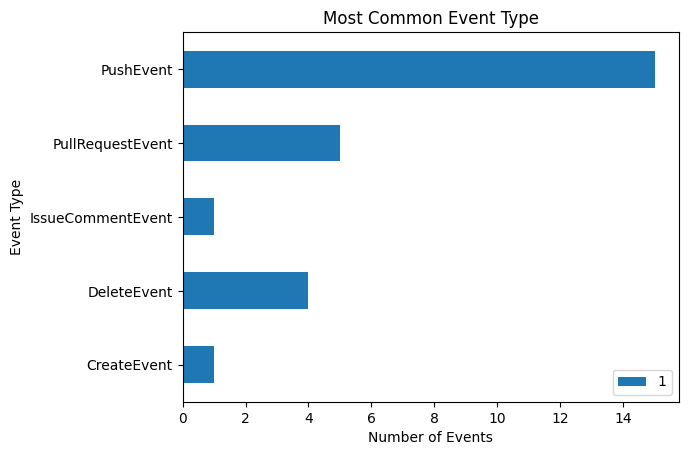

[('129681050', 2), ('40887764', 2), ('57742367', 1), ('63509684', 2), ('66235900', 19)]


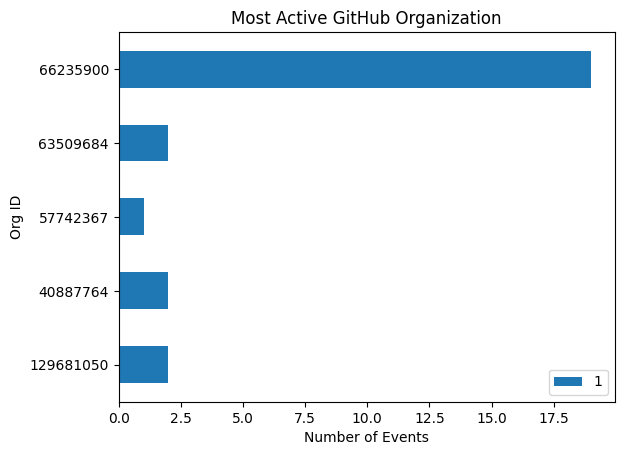

In [104]:
## Show features of databases
import matplotlib.pyplot as plt
import pandas as pd

#1. get the number of events generated from user(actor) with user_id=29139614
cur.execute("SELECT count(*) FROM EventRelation WHERE user_id=29139614")
print('1. Number of Events generated by user_id 29139614: ',cur.fetchall())

#2. number of PullRequestEvents from user(actor) with user_id=29139614
cur.execute("SELECT count(*) FROM EventRelation WHERE user_id=29139614 AND event_type = 'PullRequestEvent'")
print('2. Number of PullRequest Events by user_id 29139614',cur.fetchall())

#3. most common event type
cur.execute("select event_type,count(*) from EventRelation group by event_type")
res = cur.fetchall()
print('3. Event Type and Count: ',res)

df = pd.DataFrame.from_dict(res)
# print(df)

df.plot(x=0,y=1,kind='barh')
plt.xlabel('Number of Events')
plt.ylabel('Event Type')
plt.title('Most Common Event Type')
plt.show()

#4. how many events were made by users which were also in an org
cur.execute("SELECT Org.org_id,count(user_id) from Org inner join EventRelation on Org.org_id = EventRelation.org_id group by Org.org_id")
res=cur.fetchall()
print(res)

df = pd.DataFrame.from_dict(res)
# print(df)

df.plot(x=0,y=1,kind='barh')
plt.xlabel('Number of Events')
plt.ylabel('Org ID')
plt.title('Most Active GitHub Organization')
plt.show()


[(5,)]
[('129681050', 2), ('40887764', 2), ('57742367', 1), ('63509684', 2), ('66235900', 19)]


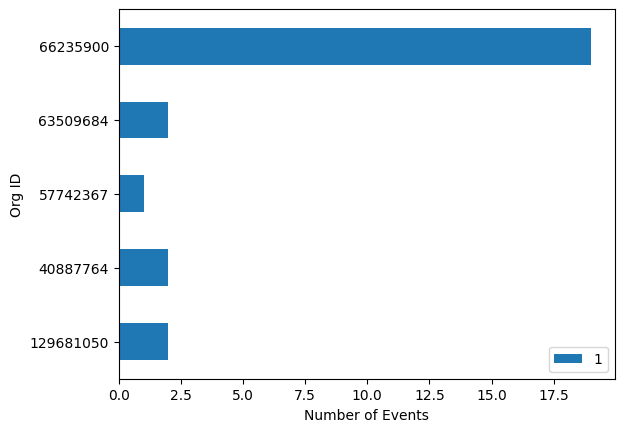

In [102]:
## Test Query Cell
cur.execute("SELECT count(distinct(org_id)) FROM Org")
print(cur.fetchall())

#4. how many events were made by users which were also in an org
cur.execute("SELECT Org.org_id,count(user_id) from Org inner join EventRelation on Org.org_id = EventRelation.org_id group by Org.org_id")
res=cur.fetchall()
print(res)

df = pd.DataFrame.from_dict(res)
# print(df)

df.plot(x=0,y=1,kind='barh')
plt.xlabel('Number of Events')
plt.ylabel('Org ID')
plt.show()
